In [2]:
import cv2


def save_coefficients(mtx, dist, path):
    """ Save the camera matrix and the distortion coefficients to given path/file. """
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_WRITE)
    cv_file.write("K", mtx)
    cv_file.write("D", dist)
    # note you *release* you don't close() a FileStorage object
    cv_file.release()


def save_stereo_coefficients(path, K1, D1, K2, D2, R, T, E, F, R1, R2, P1, P2, Q):
    """ Save the stereo coefficients to given path/file. """
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_WRITE)
    cv_file.write("K1", K1)
    cv_file.write("D1", D1)
    cv_file.write("K2", K2)
    cv_file.write("D2", D2)
    cv_file.write("R", R)
    cv_file.write("T", T)
    cv_file.write("E", E)
    cv_file.write("F", F)
    cv_file.write("R1", R1)
    cv_file.write("R2", R2)
    cv_file.write("P1", P1)
    cv_file.write("P2", P2)
    cv_file.write("Q", Q)
    cv_file.release()


def load_coefficients(path):
    """ Loads camera matrix and distortion coefficients. """
    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    camera_matrix = cv_file.getNode("K").mat()
    dist_matrix = cv_file.getNode("D").mat()

    cv_file.release()
    return [camera_matrix, dist_matrix]


def load_stereo_coefficients(path):
    """ Loads stereo matrix coefficients. """
    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    K1 = cv_file.getNode("K1").mat()
    D1 = cv_file.getNode("D1").mat()
    K2 = cv_file.getNode("K2").mat()
    D2 = cv_file.getNode("D2").mat()
    R = cv_file.getNode("R").mat()
    T = cv_file.getNode("T").mat()
    E = cv_file.getNode("E").mat()
    F = cv_file.getNode("F").mat()
    R1 = cv_file.getNode("R1").mat()
    R2 = cv_file.getNode("R2").mat()
    P1 = cv_file.getNode("P1").mat()
    P2 = cv_file.getNode("P2").mat()
    Q = cv_file.getNode("Q").mat()

    cv_file.release()
    return [K1, D1, K2, D2, R, T, E, F, R1, R2, P1, P2, Q]

In [3]:
import numpy as np
import cv2
import glob
import argparse
import sys
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
image_size = None

In [4]:
def load_image_points(left_dir, right_dir):
    global image_size
    width=9
    height = 6
    square_size =490.62
    image_format = 'bmp'
    right_prefix = 'right'
    left_prefix = 'left'
    pattern_size = (width, height)  # Chessboard size!
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((height * width, 3), np.float32)
    objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

    objp = objp * square_size  # Create real world coords. Use your metric.

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    left_imgpoints = []  # 2d points in image plane.
    right_imgpoints = []  # 2d points in image plane.

    # Left directory path correction. Remove the last character if it is '/'
    if left_dir[-1:] == '/':
        left_dir = left_dir[:-1]

    # Right directory path correction. Remove the last character if it is '/'
    if right_dir[-1:] == '/':
        right_dir = right_dir[:-1]

    # Get images for left and right directory. Since we use prefix and formats, both image set can be in the same dir.
    left_images = glob.glob(left_dir + '/' + left_prefix + '*.' + image_format)
    right_images = glob.glob(right_dir + '/' + right_prefix + '*.' + image_format)

    # Images should be perfect pairs. Otherwise all the calibration will be false.
    # Be sure that first cam and second cam images are correctly prefixed and numbers are ordered as pairs.
    # Sort will fix the globs to make sure.
    left_images.sort()
    right_images.sort()

    # Pairs should be same size. Otherwise we have sync problem.
    if len(left_images) != len(right_images):
        print("Numbers of left and right images are not equal. They should be pairs.")
        print("Left images count: ", len(left_images))
        print("Right images count: ", len(right_images))
        sys.exit(-1)

    pair_images = zip(left_images, right_images)  # Pair the images for single loop handling

    # Iterate through the pairs and find chessboard corners. Add them to arrays
    # If openCV can't find the corners in one image, we discard the pair.
    for left_im, right_im in pair_images:
        # Right Object Points
        right = cv2.imread(right_im)
        gray_right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret_right, corners_right = cv2.findChessboardCorners(gray_right, pattern_size,cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_FILTER_QUADS)

        # Left Object Points
        left = cv2.imread(left_im)
        gray_left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret_left, corners_left = cv2.findChessboardCorners(gray_left, pattern_size,cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_FILTER_QUADS)

        if ret_left and ret_right:  # If both image is okay. Otherwise we explain which pair has a problem and continue
            # Object points
            objpoints.append(objp)
            # Right points
            corners2_right = cv2.cornerSubPix(gray_right, corners_right, (5, 5), (-1, -1), criteria)
            right_imgpoints.append(corners2_right)
            # Left points
            corners2_left = cv2.cornerSubPix(gray_left, corners_left, (5, 5), (-1, -1), criteria)
            left_imgpoints.append(corners2_left)
        else:
            print("Chessboard couldn't detected. Image pair: ", left_im, " and ", right_im)
            continue

    image_size = gray_right.shape  # If you have no acceptable pair, you may have an error here.
    return [objpoints, left_imgpoints, right_imgpoints]

In [5]:
objp, leftp, rightp =load_image_points('Chessboard/Chessboard_left' ,'Chessboard/Chessboard_right')

In [6]:
def calibrate(dirpath, prefix):
    width =9
    height=6
    square_size =490.62
    image_format = 'bmp'
    """ Apply camera calibration operation for images in the given directory path. """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((height*width, 3), np.float32)
    objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

    objp = objp * square_size  # Create real world coords. Use your metric.

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    # Directory path correction. Remove the last character if it is '/'
    if dirpath[-1:] == '/':
        dirpath = dirpath[:-1]

    # Get the images
    images = glob.glob(dirpath+'/' + prefix + '*.' + image_format)

    # Iterate through the pairs and find chessboard corners. Add them to arrays
    # If openCV can't find the corners in an image, we discard the image.
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (width, height), None)

        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            # Show the image to see if pattern is found ! imshow function.
            img = cv2.drawChessboardCorners(img, (width, height), corners2, ret)
            imS = cv2.resize(img, (960, 940)) 
            cv2.imshow('img',imS)
            cv2.waitKey(100)
            
    cv2.destroyAllWindows()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return [ret, mtx, dist, rvecs, tvecs]


In [7]:
ret, mtx, dist, rvecs, tvecs = calibrate('Chessboard/Chessboard_left', 'left',)
save_coefficients(mtx, dist, 'Parameters/cameraparameters_left.txt')


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/uduwela/.local/lib/python3.10/site-packages/cv2/qt/plugins"


In [8]:
ret, mtx, dist, rvecs, tvecs = calibrate('Chessboard/Chessboard_right', 'right',)
save_coefficients(mtx, dist, 'Parameters/cameraparameters_right.txt')

In [9]:
K1, D1 = load_coefficients('Parameters/cameraparameters_left.txt')
K2, D2 = load_coefficients('Parameters/cameraparameters_right.txt')

print(K1)
print(K2)
print(D1)
print(D2)


[[2.35064701e+03 0.00000000e+00 1.25671731e+03]
 [0.00000000e+00 2.35357901e+03 1.03782870e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[2.37599380e+03 0.00000000e+00 1.29465710e+03]
 [0.00000000e+00 2.37130551e+03 1.02885447e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.14144529  0.12560418 -0.0009506   0.00228876 -0.07417139]]
[[-0.14008837  0.0614601  -0.00016478  0.00422068  0.03470469]]


In [10]:
flag = 0
# flag |= cv2.CALIB_FIX_INTRINSIC
flag |= cv2.CALIB_USE_INTRINSIC_GUESS
save_file = 'Parameters/cameraparameters.txt'
image_size = None
ret, K1, D1, K2, D2, R, T, E, F = cv2.stereoCalibrate(objp, leftp, rightp, K1, D1, K2, D2, image_size)
print("Stereo calibration rms: ", ret)

R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(K1, D1, K2, D2, image_size, R, T, flags=cv2.CALIB_ZERO_DISPARITY, alpha=1)
print("Stereo R1",R1)
print("stereo R2",R2)

print("stereo K1",K1)
print("stereo K2",K2)

print("Rotational",R)
print("Trasation",T)

print("distCoeffs1",D1)
print("distCoeffs2",D2)



save_stereo_coefficients(save_file, K1, D1, K2, D2, R, T, E, F, R1, R2, P1, P2,Q) 


Stereo calibration rms:  2.249468280615339
Stereo R1 [[ 0.9965709   0.00879269  0.08227475]
 [-0.00835393  0.999949   -0.0056756 ]
 [-0.08232046  0.00496883  0.99659352]]
stereo R2 [[ 0.98346157 -0.02417522 -0.17949621]
 [ 0.02513499  0.99967934  0.00307432]
 [ 0.17936433 -0.00753511  0.98375386]]
stereo K1 [[2.35064701e+03 0.00000000e+00 1.25671731e+03]
 [0.00000000e+00 2.35357901e+03 1.03782870e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
stereo K2 [[2.37599380e+03 0.00000000e+00 1.29465710e+03]
 [0.00000000e+00 2.37130551e+03 1.02885447e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotational [[ 0.96511385  0.03467221  0.25952474]
 [-0.03182328  0.99937835 -0.01517224]
 [-0.25988946  0.00638401  0.96561727]]
Trasation [[-4013.88841414]
 [   98.66847337]
 [  732.59372098]]
distCoeffs1 [[-0.14144529  0.12560418 -0.0009506   0.00228876 -0.07417139]]
distCoeffs2 [[-0.14008837  0.0614601  -0.00016478  0.00422068  0.03470469]]


In [11]:
import cv2
image_size = (2048,2448)
#left_img =cv2.imread('Chessboard/Chessboard_left/left_01.bmp')

imgL = cv2.imread('Chessboard/Chessboard_left/left_01.bmp',cv2.IMREAD_GRAYSCALE)

#(hl, wl, cl) = imgL.shape[:3]
# display the image width, height, and number of channels to our
# terminal
#print("width: {} pixels".format(wl))
#print("height: {}  pixels".format(hl))
#print("channels: {}".format(cl))


imgR = cv2.imread('Chessboard/Chessboard_right/right_01.bmp',cv2.IMREAD_GRAYSCALE)
#cv2.imshow("SIFT Keypoints", imgL)

h1,  w1 = imgL.shape[:2]
h2,  w2 = imgL.shape[:2]

mapx1, mapy1 = cv2.initUndistortRectifyMap(K1, D1, R1, P1, (h1,w1), cv2.CV_32FC1)

Left_rectified = cv2.remap(imgL, mapx1, mapy1, cv2.INTER_LINEAR,cv2.BORDER_CONSTANT)
mapx2, mapy2 = cv2.initUndistortRectifyMap(K2, D2, R2,P2,(h2,w2), cv2.CV_32FC1)
Right_rectified = cv2.remap(imgR, mapx2, mapy2, cv2.INTER_LINEAR,cv2.BORDER_CONSTANT)



In [12]:
import matplotlib.pyplot as plt
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(imgL,None)

kp2, des2 = sift.detectAndCompute(imgR,None)

#print(des1)
#print(des2)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 3)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)


# Draw the keypoint matches between both pictures
# Still based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=cv2.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv2.drawMatchesKnn(
    imgL, kp1, imgR, kp2, matches, None, **draw_params)
key_point_matches = cv2.resize(keypoint_matches, (960, 940)) 
   
#cv2.imshow("Keypoint matches", key_point_matches)
#cv2.waitKey(0)


In [13]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [14]:
# ------------------------------------------------------------
# STEREO RECTIFICATION

# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

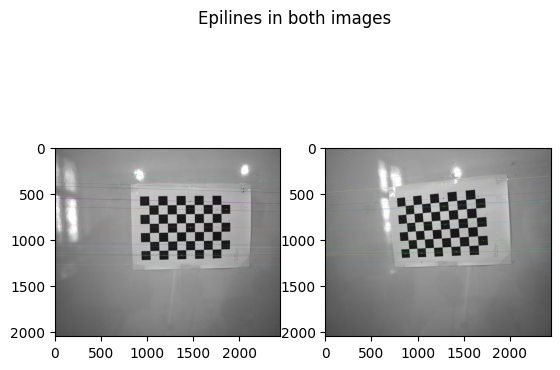

In [15]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(imgL, imgR, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(imgR, imgL, lines2, pts2, pts1)

epilines = cv2.resize(img5, (960, 940))
#cv2.imshow("Keypoint matches", epilines)
#cv2.waitKey(10000)
#cv2.destroyAllWindows()
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.show()

In [16]:
# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1 = imgL.shape
h2, w2 = imgR.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1)
)

In [17]:
# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv2.warpPerspective(imgL, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(imgR, H2, (w2, h2))
cv2.imwrite("rectified_1.png", img1_rectified)
cv2.imwrite("rectified_2.png", img2_rectified)

True

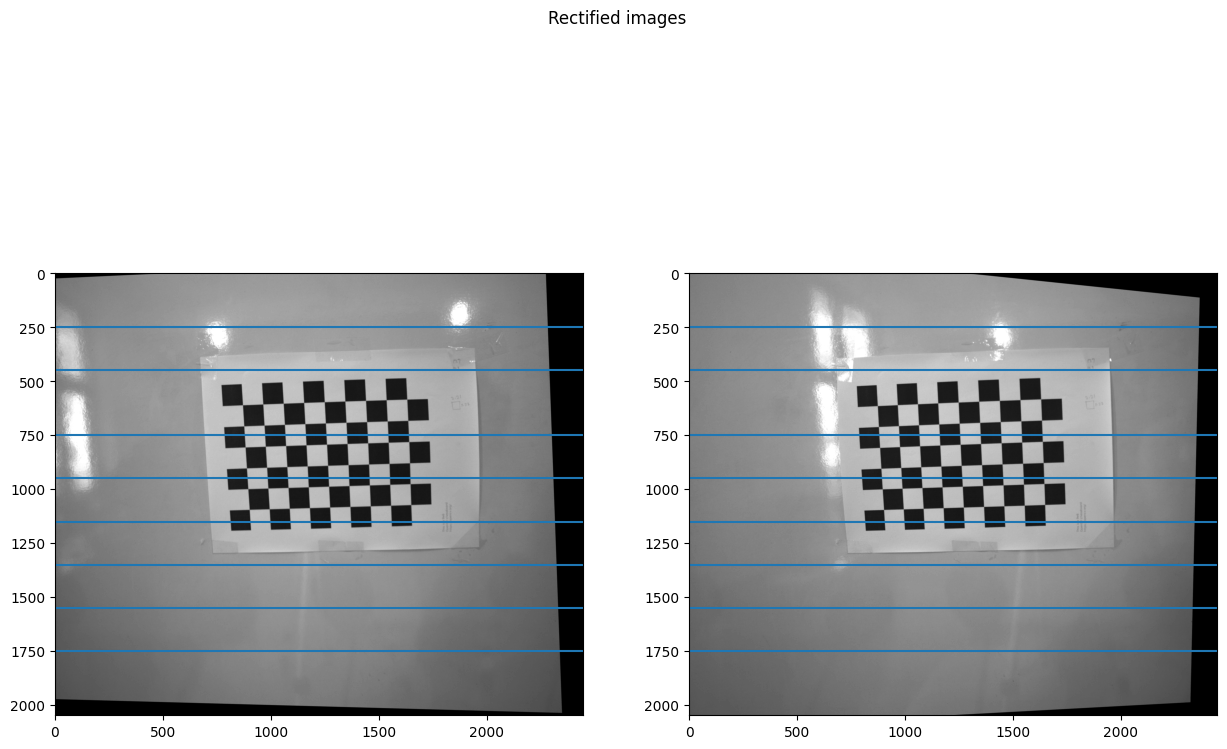

In [18]:
# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
axes[0].axhline(750)
axes[1].axhline(750)
axes[0].axhline(950)
axes[1].axhline(950)
axes[0].axhline(1150)
axes[1].axhline(1150)
axes[0].axhline(1350)
axes[1].axhline(1350)
axes[0].axhline(1550)
axes[1].axhline(1550)
axes[0].axhline(1750)
axes[1].axhline(1750)
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()

In [19]:
#Function that Downsamples image x number (reduce_factor) of times. 
def downsample_image(image, reduce_factor):
	for i in range(0,reduce_factor):
		#Check if image is color or grayscale
		if len(image.shape) > 2:
			row,col = image.shape[:2]
		else:
			row,col = image.shape

		image = cv2.pyrDown(image, dstsize= (col//2, row // 2))
	return image

In [20]:
#Get height and width. Note: It assumes that both pictures are the same size. They HAVE to be same size and height. 
hl,wl = imgL.shape[:2]
hr,wr = imgR.shape[:2]

#Get optimal camera matrix for better undistortion 
new_camera_matrix_l, roi_l = cv2.getOptimalNewCameraMatrix(K1,D1,(wl,hl),1,(wl,hl))
new_camera_matrix_r, roi_r = cv2.getOptimalNewCameraMatrix(K2,D2,(wr,hr),1,(wr,hr))


#Undistort images
img_1_undistorted_l = cv2.undistort(imgL, K1, D1, None, new_camera_matrix_l)
img_2_undistorted_r = cv2.undistort(imgR, K1, D2, None, new_camera_matrix_r)

img_1_downsampled_l = downsample_image(img_1_undistorted_l,1)
img_2_downsampled_r = downsample_image(img_2_undistorted_r,1)

#cv2.imwrite('undistorted_left.jpg', img_1_downsampled)
#cv2.imwrite('undistorted_right.jpg', img_2_downsampled)

In [25]:
#Set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error. 
win_size = 5
min_disp = -1
max_disp = 63 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16

#Create Block matching object. 
stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
	numDisparities = num_disp,
	blockSize = 5,
	uniquenessRatio = 5,
	speckleWindowSize = 5,
	speckleRange = 5,
	disp12MaxDiff = 2,
	P1 = 8*3*win_size**2,#8*3*win_size**2,
	P2 =32*3*win_size**2) #32*3*win_size**2)

In [39]:
#Compute disparity map
print ("\nComputing the disparity  map...")
disparity_map = stereo.compute(img_1_downsampled_l, img_2_downsampled_r)


Computing the disparity  map...


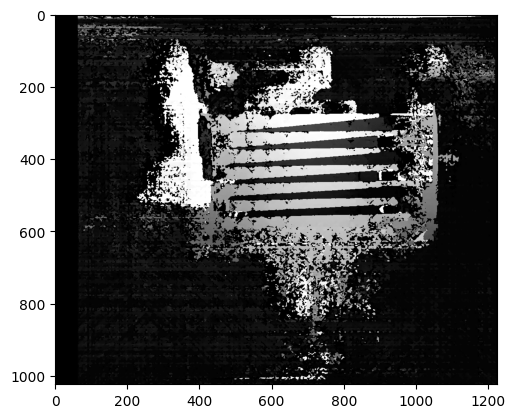

In [40]:
#Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
plt.imshow(disparity_map,'gray')
plt.show()

In [37]:

#Reproject points into 3D
points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
#Get color points
colors = cv2.cvtColor(img_1_downsampled_l, cv2.COLOR_BGR2RGB)


In [41]:
#Get rid of points with value 0 (i.e no depth)
mask_map = disparity_map > disparity_map.min()


In [42]:
#Mask colors and points. 
output_points = points_3D[mask_map]
output_colors = colors[mask_map]


In [43]:
#Define name for output file
output_file = 'Outputs/reconstructed.ply'


In [44]:
#Function to create point cloud file
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [45]:
#Generate point cloud 
print ("\n Creating the output file... \n")
create_output(output_points, output_colors, output_file)


 Creating the output file... 



In [34]:
#import open3d as o3d
#point_cloud = o3d.io.read_point_cloud("Outputs/reconstructed.ply", format="ply")
#vis = o3d.visualization.Visualizer()
#vis.create_window()
#vis.get_render_option().point_color_option = o3d.visualization.PointColorOption.Color
#vis.get_render_option().point_size = 3.0
#vis.add_geometry(point_cloud)
#vis.capture_screen_image("Outputs/2D_image_converted_rotated2.jpg", do_render=True)